'''
Code adapted from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViLT/Fine_tuning_ViLT_for_VQA.ipynb 
Original ViLT paper: https://arxiv.org/abs/2102.03334

Description: Fine-tuning ViLT with a trainable head for detecting driving contexts in autonomous driving.

Author: Shounak Sural, Carnegie Mellon University
'''

In [1]:
!pip install torch
!pip install -q transformers[torch]

     |████████████████████████████████| 797.1 MB 12 kB/s  eta 0:00:019   |██▌                             | 61.3 MB 2.3 MB/s eta 0:05:20     |███▏                            | 79.9 MB 1.5 MB/s eta 0:08:09     |█████████████                   | 325.7 MB 5.3 MB/s eta 0:01:29     |███████████████                 | 373.8 MB 5.2 MB/s eta 0:01:21     |█████████████████               | 424.4 MB 6.2 MB/s eta 0:01:01     |███████████████████▌            | 486.6 MB 7.0 MB/s eta 0:00:45        | 564.1 MB 25.0 MB/s eta 0:00:10
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
ERROR: visions 0.7.6 has requirement numpy>=1.23.2, but you'll have numpy 1.17.4 which is incompatible.


In [2]:
root_folder=[ADD YOUR ROOT FOLDER HERE]

In [3]:
import json

# Opening JSON file
f = open(root_folder+'DrivingContexts/images/drivingcontexts_questions.json')
# Return JSON object as dictionary
data_questions = json.load(f)
print(data_questions.keys())

dict_keys(['questions'])


In [4]:
questions = data_questions['questions']
print("Number of questions:", len(questions))

Number of questions: 35208


In [5]:
#Visualize sample questions

print(questions[0])
print(questions[1])

{'image_id': 'pittsburgh/00000000.jpg', 'question': 'Are we driving indoors?', 'question_id': 'pittsburgh/00000000.jpg_0'}
{'image_id': 'pittsburgh/00000000.jpg', 'question': 'Are we driving outdoors?', 'question_id': 'pittsburgh/00000000.jpg_1'}


In [6]:
import re
from typing import Optional

filename_re = re.compile(r".*(\d{12})\.((jpg)|(png))")

# source: https://github.com/allenai/allennlp-models/blob/a36aed540e605c4293c25f73d6674071ca9edfc3/allennlp_models/vision/dataset_readers/vqav2.py#L141
def id_from_filename(filename: str) -> Optional[int]:
    return filename

In [7]:
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm

# root at which all images are stored
root = root_folder+'DrivingContexts/images'
file_names = [f for f in tqdm(listdir(root)) if isfile(join(root, f))]
print(file_names)

  0%|          | 0/15 [00:00<?, ?it/s]

['drivingcontexts_questions.json', 'kitti_outputs.txt', 'drivingcontexts_annotations.json', 'nuscenes_outputs.txt', 'annotations_old_to_vqa_format.ipynb', 'combined_annotations.json', 'web_outputs.txt', 'annotations.txt', 'annotations_handannotated_final.json', 'pittsburgh_outputs.txt', 'convert_annotations_to_json.ipynb']


pittsburgh/00000000.jpg


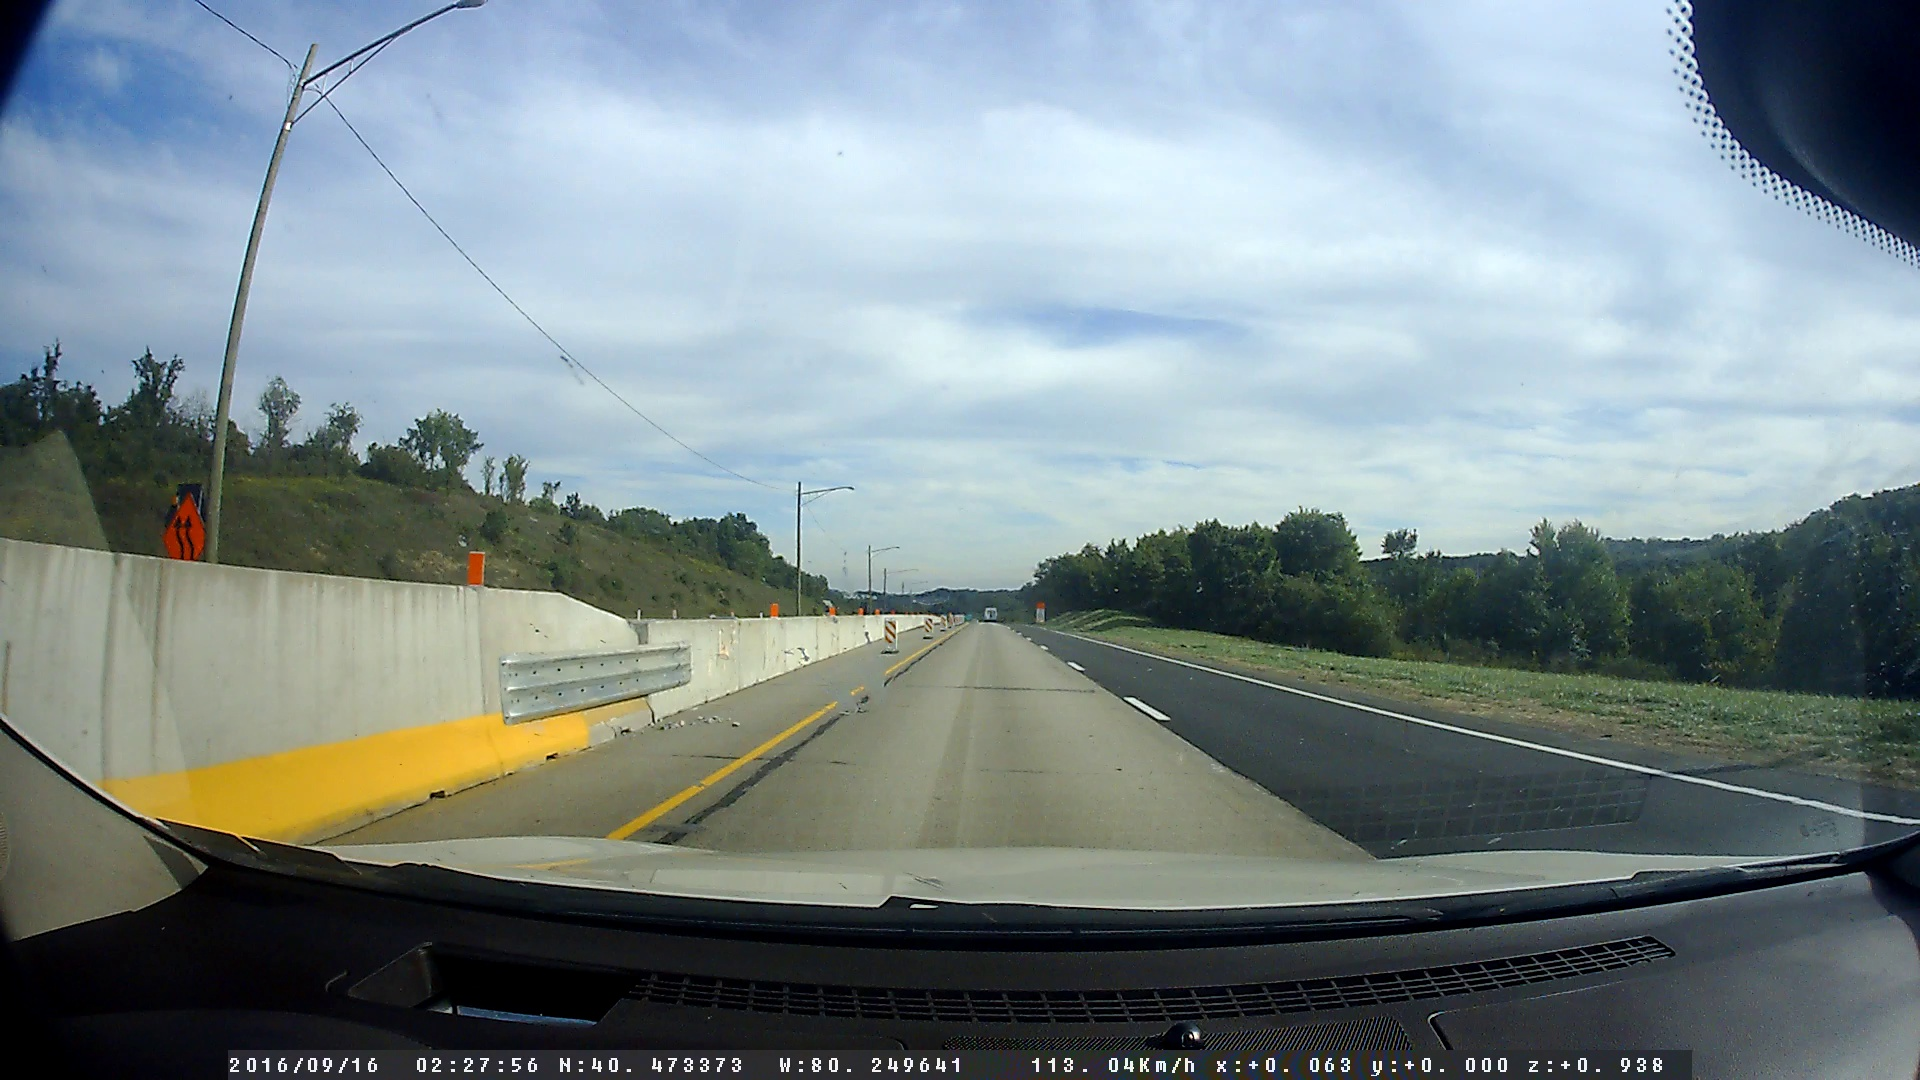

In [8]:
from PIL import Image
print(questions[0]['image_id'])
path = root_folder+'DrivingContexts/images/'+questions[0]['image_id']
image = Image.open(path).convert("RGB")
image

In [9]:
import json

# Read annotations
f = open(root_folder+'DrivingContexts/images/drivingcontexts_annotations.json')

# Return JSON object as dictionary
data_annotations = json.load(f)
#print(data_annotations.keys())

In [10]:
annotations = data_annotations['annotations']

In [11]:
print("Number of annotations:", len(annotations))

Number of annotations: 35208


In [12]:
annotations[0]

{'answer_type': 'yes/no',
 'multiple_choice_answer': 'no',
 'question_type': 'none of the above',
 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 0},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9}],
 'image_id': 'pittsburgh/00000000.jpg',
 'question_id': 'pittsburgh/00000000.jpg_0'}

In [13]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [14]:
from tqdm.notebook import tqdm

def get_score(count: int) -> float:
    return min(1.0, count / 3)

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

  0%|          | 0/35208 [00:00<?, ?it/s]

Let's verify an example:

In [15]:
annotations[0]

{'answer_type': 'yes/no',
 'multiple_choice_answer': 'no',
 'question_type': 'none of the above',
 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 0},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9}],
 'image_id': 'pittsburgh/00000000.jpg',
 'question_id': 'pittsburgh/00000000.jpg_0',
 'labels': [9],
 'scores': [1.0]}

In [16]:
labels = annotations[0]['labels']
print([config.id2label[label] for label in labels])

['no']


In [17]:
scores = annotations[0]['scores']
print(scores)

[1.0]


In [18]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(root_folder+"DrivingContexts/images/"+annotation['image_id']).convert("RGB")
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimensionv
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [19]:
from transformers import ViltProcessor
import random 

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
import numpy as np
indices=np.arange(len(questions))
old_questions = questions
old_annotations = annotations
temp = list(zip(questions, annotations,indices))
random.shuffle(temp)
res1, res2, res3 = zip(*temp)
questions, annotations, shuffled_indices = list(res1), list(res2), list(res3)


/home/rtml/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch



In [ ]:
data_split = 0.7
from transformers import ViltForQuestionAnswering

for shots in [1*24,4*24,16*24,64*24,256*24,int(data_split*len(questions))]:
        dataset = VQADataset(questions=questions[:shots],
                        annotations=annotations[:shots],
                        processor=processor)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa",
                                                        id2label=config.id2label,
                                                        label2id=config.label2id)

        model=torch.nn.DataParallel(model)                                                 

        model.to(device)
        train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=256, shuffle=False)

        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
        from tqdm import tqdm
        num_epochs=10
        model.train()
        for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
                for batch in tqdm(train_dataloader):
                        # get the inputs;
                        batch = {k:v.to(device) for k,v in batch.items()}

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        outputs = model(**batch)
                        loss = outputs.loss
                        loss.sum().backward()
                        optimizer.step()

        torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss}, 
                'models_vilt/model_'+str(int(shots/24))+'shot'+'.pth')

        torch.cuda.empty_cache()


In [ ]:

eval_dataset = VQADataset(questions=questions[int(data_split*len(questions)):],
                     annotations=annotations[int(data_split*len(questions)):],
                     processor=processor)                     

In [ ]:
for shots in [0,1*24,4*24,16*24,64*24,256*24,int(data_split*len(questions))]:
  print(str(int(shots/24))+'shot')
  if(shots!=0):
    checkpoint = torch.load('models_vilt/model_'+str(int(shots/24))+'shot'+'.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
  else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa",
                                                        id2label=config.id2label,
                                                        label2id=config.label2id)
    model=torch.nn.DataParallel(model)                                                 
    model.to(device)


  eval_count=len(eval_dataset)
  count=0
  predicted_answers=[]
  annotated_answers=[]
  file_pred=open('predicted_answers_'+str(shots)+'.txt', 'w')
  file_annot=open('annotated_answers_'+str(shots)+'.txt', 'w')
  for item in tqdm(range(eval_count)):
    count+=1
    example=eval_dataset[item]
    processor.decode(example['input_ids'])
    # add batch dimension + move to GPU
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

    # forward pass
    outputs = model(**example)
    logits = outputs.logits
    predicted_classes = torch.sigmoid(logits)

    probs, classes = torch.topk(predicted_classes, 5)

    answer=classes.squeeze().tolist()[0]

    predicted_answers.append(config.id2label[answer])
    annotated_answers.append(old_annotations[shuffled_indices[int(data_split*len(questions))+item]]["answers"][0]["answer"]) 

    file_pred.write(config.id2label[answer]+'\n')
    file_annot.write(old_annotations[shuffled_indices[int(data_split*len(questions))+item]]["answers"][0]["answer"]+'\n')
  
  binary_predictions = list(map(lambda x: 1 if x == "yes" else (0 if x == "no" else -1), predicted_answers))
  binary_annotations = list(map(lambda x: 1 if x == "yes" else (0 if x == "no" else -1), annotated_answers))

  tp_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==1 and binary_annotations[i]==1])
  tn_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==0 and binary_annotations[i]==0])
  fp_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==1 and binary_annotations[i]==0])
  fn_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==0 and binary_annotations[i]==1])


  print("True positives:", tp_count)
  print("True negatives:",tn_count)
  print("False positives:",fp_count)
  print("False negatives:",fn_count)

  print("Precision: ", tp_count/(tp_count+fp_count))
  print("Recall: ", tp_count/(tp_count+fn_count))
  print("F1 score: ", 2*tp_count/(2*tp_count+fp_count+fn_count))
  print("Accuracy: ", (tp_count+tn_count)/(tp_count+tn_count+fp_count+fn_count))

  print((tp_count+tn_count+fp_count+fn_count))


1026shot


  0%|          | 0/12368 [00:00<?, ?it/s]

/home/rtml/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
print(questions[0])
print(annotations[0])

{'image_id': '2024_0417_202952_0039-000687.png', 'question': 'Are we driving indoors?', 'question_id': '2024_0417_202952_0039-000687.png_0'}
{'answer_type': 'yes/no', 'multiple_choice_answer': 'no', 'question_type': 'none of the above', 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 0}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9}], 'image_id': '2024_0417_202952_0039-000687.png', 'question_id': '2024_0417_202952_0039-000687.png_0', 'labels': [9], 'scores': [1.0

In [ ]:
binary_predictions = list(map(lambda x: 1 if x == "yes" else (0 if x == "no" else -1), predicted_answers))
binary_annotations = list(map(lambda x: 1 if x == "yes" else (0 if x == "no" else -1),
 annotated_answers))

tp_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==1 and binary_annotations[i]==1])
tn_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==0 and binary_annotations[i]==0])
fp_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==1 and binary_annotations[i]==0])
fn_count=sum([1 for i in range(len(binary_predictions)) if binary_predictions[i]==0 and binary_annotations[i]==1])


print("True positives:", tp_count)
print("True negatives:",tn_count)
print("False positives:",fp_count)
print("False negatives:",fn_count)

print("Precision: ", tp_count/(tp_count+fp_count))
print("Recall: ", tp_count/(tp_count+fn_count))
print("F1 score: ", 2*tp_count/(2*tp_count+fp_count+fn_count))
print("Accuracy: ", (tp_count+tn_count)/(tp_count+tn_count+fp_count+fn_count))

print((tp_count+tn_count+fp_count+fn_count))

True positives: 2200
True negatives: 8426
False positives: 953
False negatives: 789
Precision:  0.6977481763399936
Recall:  0.7360321177651389
F1 score:  0.7163790296320417
Accuracy:  0.8591526520051747
12368
